## Adaptive Diabetes-risk Classifier

## Objective:

Build an adaptive diabetes-risk classifier that can improve itself when the data changes. You’ll demonstrate three kinds of adaptability:

1- Data tailoring — when you add new features, the model re-trains and improves.

2- Clustering + prediction — learn patient “phenotypes” with K-Means and use the cluster label to boost prediction.

3- Model adaptation — detect a cohort/distribution shift (e.g., younger vs older patients) and update the model so it stays accurate.



# 1. Introduction:

- You start with a baseline logistic regression on the diabetes dataset.

- Next, you engineer meaningful features (e.g., Insulin/Glucose ratio, BMI×Glucose). You re-tune the model and compare metrics to show gains from richer inputs.

- Then, you fit K-Means on training data, append the cluster_id as a new feature, and re-train. The cluster captures hidden structure (patient profiles) that helps classification.

- Finally, you simulate a real-world shift by splitting data into two cohorts (e.g., YoungAdults vs OlderAdults). You check drift with a KS test, then adapt by re-learning clusters and re-tuning the classifier on combined data, evaluating on the new cohort to confirm robustness.



# 2. Implementation:

## 2.1 Evaluation Function

- **Goal:** Create one function that helps us check model performance in the same way every time.

- **Why:** It is easier to compare models if we always use the same metrics

- **Classification report:** precision, recall, and F1-score for each class

- **ROC-AUC score:** tells how well the model separates classes

- **Confusion matrix:** shows numbers of correct and wrong predictions

- **Impact:** Students can clearly see where the model is doing well or failing — for example, how many “sick” people are missed (false negatives).



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 1: Install and Import Requireds

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Standard numeric + data libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn model building utilities
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV # Splits + CV search
from sklearn.preprocessing import StandardScaler # Feature scaling (mean 0, std 1)
from sklearn.pipeline import Pipeline # Chain steps into one model
from sklearn.linear_model import LogisticRegression # Our classifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix  # Model evaluation metrics
from sklearn.cluster import KMeans  # Unsupervised clustering to create "phenotypes"

# Statistics (for simple drift detection)
from scipy.stats import ks_2samp # Kolmogorov–Smirnov test: compare two distributions



**Kolmogorov-Smirnov test**:
 https://medium.com/@data-overload/the-kolmogorov-smirnov-test-56e18ba621de


In [4]:
# 0) Configuration & utilities

RANDOM_STATE = 42                 # Fixed seed for reproducibility
N_CLUSTERS = 4                    # Number of KMeans clusters (phenotype groups)
CV_SPLITS = 5                     # Number of folds for cross-validation
SCORING = "f1"                    # Optimize for F1 (balance of precision & recall)
EPS = 1e-6                        # Tiny constant to avoid divide-by-zero
DRIFT_PVAL_THRESHOLD = 0.01       # KS-test p-value threshold for declaring "drift detected"


def evaluate(model, X, y, title="Evaluation"):
  """
    Evaluate a trained classifier with common metrics and print results.
    This function:
      - gets predictions and predicted probabilities,
      - prints a classification report (precision/recall/F1 by class),
      - prints ROC-AUC (threshold-free quality),
      - prints the confusion matrix (TN, FP / FN, TP).
  """

  y_pred = model.predict(X)
  y_proba = model.predict_proba(X)[:, 1]
  print(f"\n=== {title} ===")
  print(classification_report(y, y_pred, digits=3, target_names = ['NO (Outcome 0)', 'Yes (Outcome 1)']))
  print("ROC-AUC:", round(roc_auc_score(y, y_proba), 3))
  class_names = ['NO (Outcome 0)', 'Yes (Outcome 1)']
  nb_classes = len(class_names)
  # print(nb_classes)
  cm = confusion_matrix(y, y_pred)
  plt.figure(figsize = (4,4))
  sns.heatmap(
      cm,
      cmap = 'Blues',
      linecolor = 'black',
      linewidth = 1,
      annot = True,
      fmt = '',
      xticklabels = class_names,
      yticklabels = class_names)


def ks_drift(old_df, new_df, cols, p_thresh=DRIFT_PVAL_THRESHOLD):

  """
  Lightweight drift check using the Kolmogorov–Smirnov test per numeric column.
  Compares distributions of 'old_df[col]' vs 'new_df[col]'.
  Returns True if ANY column shows p-value < threshold (i.e., statistically different).
  """
  for c in cols:                                               # Iterate over shared columns
      if c in old_df.columns and c in new_df.columns:          # Only test if both datasets have this column
          a = pd.to_numeric(old_df[c], errors="coerce")        # Convert to numeric (coerce errors to NaN)
          b = pd.to_numeric(new_df[c], errors="coerce")        # Convert to numeric for new data
          a = a.replace([np.inf, -np.inf], np.nan).dropna()    # Remove inf and NaN to clean arrays
          b = b.replace([np.inf, -np.inf], np.nan).dropna()    # Same cleaning for new data
          if len(a) > 30 and len(b) > 30:                      # Guard: need enough samples to test
              _, p = ks_2samp(a, b)                            # Perform KS test (returns statistic, p-value)
              if p < p_thresh:                                 # If p is small, distributions differ => drift
                  return True                                  # Early return on first detected drift
  return False                                                 # No column showed significant drift


## Step 2: load and explore the data

In [5]:
# 1) Load data  (adjust path if needed)

df = pd.read_csv('/content/drive/MyDrive/UEL-Intelligence-System-Lab/diabetes_1.csv')                            # Load dataset from CSV

X_full = df.drop(columns=["Outcome"]).copy()                    # All input features (drop the target column)
y_full = df["Outcome"].astype(int).copy()                       # Target labels as integers (0 or 1)

numeric_cols = X_full.columns.tolist()                          # Store column names (assumed numeric in Pima dataset)



In [6]:
X_full.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [7]:
X_full.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [8]:
len(X_full)

768

In [9]:
# Missing values
print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [10]:
df['Outcome'].value_counts()

,count
Outcome,
0,500
1,268


## Step 3: BASELINE (no tailoring, no clustering)

- Baseline Model (before improvements)

- Goal: Train a simple Logistic Regression model as our starting point.

- Why: We need a baseline to measure future improvements.

**Logistic Regression:** https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

**Model Pipeline:** https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [11]:
# 2) BASELINE (no tailoring, no clustering)
#    Pipeline: Standardize -> LogisticRegression

scaler = StandardScaler()                                       # Create a standard scaler (fit on training data only)
logreg = LogisticRegression(                                    # Create Logistic Regression classifier
    max_iter=500,                                               # Allow more iterations for convergence
    solver="liblinear",                                         # Good solver for small datasets; supports L1/L2
    random_state=RANDOM_STATE                                   # Reproducibility
)

pipe_baseline = Pipeline([                                      # Build a pipeline that scales then classifies
    ("scaler", scaler),                                         # Step 1: standardize features
    ("clf", logreg)                                             # Step 2: logistic regression
])

## Step 4: Hyperparam grid for logistic regression (L1/L2 and strength C)

In [12]:
# Hyperparam grid for logistic regression (L1/L2 and strength C)

param_grid = {                                                  # Hyperparameters to search over
    "clf__penalty": ["l1", "l2"],                               # Regularization type: L1 (sparse) or L2 (ridge)
    "clf__C": [0.01, 0.1, 1, 3, 10]                             # Regularization strength (inverse); larger = weaker reg
}

## Step 5: Stratified split to preserve class balances

**GridSearch CV:** https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Baseline best params: {'clf__C': 0.1, 'clf__penalty': 'l1'}

=== Baseline (no tailoring, no clusters) ===
                 precision    recall  f1-score   support

 NO (Outcome 0)      0.743     0.810     0.775       100
Yes (Outcome 1)      0.578     0.481     0.525        54

       accuracy                          0.695       154
      macro avg      0.660     0.646     0.650       154
   weighted avg      0.685     0.695     0.688       154

ROC-AUC: 0.812


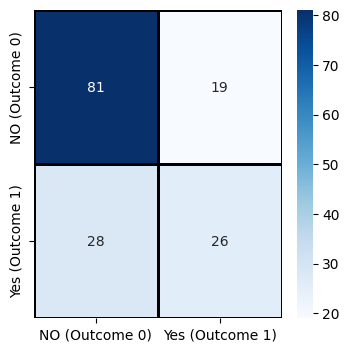

In [13]:
# Stratified split to preserve class balance
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_full, y_full, test_size = 0.2, stratify = y_full, random_state = RANDOM_STATE
)

cv = StratifiedKFold(n_splits = CV_SPLITS, shuffle = True, random_state = RANDOM_STATE)  # Stratified CV preserves class ratio

gs_base = GridSearchCV(                                         # Cross-validated hyperparameter search
    estimator = pipe_baseline,                                    # Our pipeline (scaler + LR)
    param_grid = param_grid,                                      # Grid of hyperparameters to test
    cv = cv,                                                      # Stratified K-fold
    scoring = SCORING,                                            # Optimize F1 score
    n_jobs = -1                                                   # Use all CPU cores available
)
gs_base.fit(X_train_base, y_train_base)                         # Fit CV search on training data

baseline_model = gs_base.best_estimator_                        # Extract the best pipeline (scaler + LR with best params)
print("Baseline best params:", gs_base.best_params_)            # Show chosen hyperparameters
evaluate(baseline_model, X_test_base, y_test_base,              # Evaluate on held-out test set
         title="Baseline (no tailoring, no clusters)")

## A. DATA TAILORING :

- Goal: Create new useful features from the existing ones.

- Why: Sometimes new combinations of variables can help the model learn better patterns.

- How: We start from the dataset and add two new features:

- 1-Insulin_over_Glucose = Insulin / (Glucose + small value) → shows the balance between insulin and glucose.

- 2-BMI_x_Glucose = BMI × Glucose → combines body mass and sugar level to capture health interaction.

- Impact: These new features give the model more information and can improve prediction quality. Students will see that even simple changes in data can improve results.


In [14]:
X_full.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [15]:
print(EPS)

1e-06


## 1- DATA TAILORING (engineer new predictive signals)

In [16]:
X_full.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [17]:
X_full["Insulin_over_Glucose"] = (                      # Create ratio feature (stabilized division)
        X_full["Insulin"] / (X_full["Glucose"] + EPS)   # Add small EPS to avoid divide-by-zero
    )
X_full["Insulin_over_Glucose"].head()

,Insulin_over_Glucose
0,0.000000
1,0.000000
2,0.000000
3,1.056180
4,1.226277


In [18]:
X_full["BMI_x_Glucose"] = (                             # Create interaction feature (product)
        X_full["BMI"] * X_full["Glucose"]
        )

X_full["BMI_x_Glucose"].head()

,BMI_x_Glucose
0,4972.8
1,2261.0
2,4263.9
3,2500.9
4,5904.7


In [19]:
# Feature Engineering:
# - Insulin_over_Glucose: stabilised ratio
# - BMI_x_Glucose: interaction capturing joint effect
X_tailored = X_full.copy()                                      # Start from original features

if {"Insulin", "Glucose"}.issubset(X_tailored.columns):         # If both columns exist
    X_tailored["Insulin_over_Glucose"] = (                      # Create ratio feature (stabilized division)
        X_tailored["Insulin"] / (X_tailored["Glucose"] + EPS)   # Add small EPS to avoid divide-by-zero
    )

if {"BMI", "Glucose"}.issubset(X_tailored.columns):             # If both columns exist
    X_tailored["BMI_x_Glucose"] = (                             # Create interaction feature (product)
        X_tailored["BMI"] * X_tailored["Glucose"]
    )


## 2- Re-split to simulate "new feature arrived, re-train


Data Tailoring best params: {'clf__C': 0.01, 'clf__penalty': 'l2'}

=== After Data Tailoring (engineered features added) ===
                 precision    recall  f1-score   support

 NO (Outcome 0)      0.784     0.800     0.792       100
Yes (Outcome 1)      0.615     0.593     0.604        54

       accuracy                          0.727       154
      macro avg      0.700     0.696     0.698       154
   weighted avg      0.725     0.727     0.726       154

ROC-AUC: 0.813


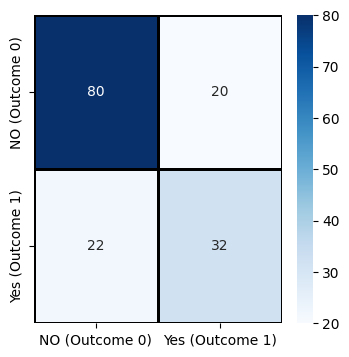

In [20]:
# Re-split to simulate "new feature arrived, re-train"
X_train_tailored, X_test_tailored, y_train_tailored, y_test_tailored = train_test_split(  # New split to simulate "feature arrived"
    X_tailored, y_full, test_size=0.2, stratify=y_full, random_state=RANDOM_STATE
)

pipe_tailored = Pipeline([                                      # Same modeling recipe (scale -> LR)
    ("scaler", StandardScaler()),                               # Scale features
    ("clf", LogisticRegression(max_iter=500, solver="liblinear", random_state=RANDOM_STATE))
])

gs_tailored = GridSearchCV(                                     # CV search again (new feature space)
    estimator=pipe_tailored,
    param_grid=param_grid,
    cv=cv,
    scoring=SCORING,
    n_jobs=-1
)
gs_tailored.fit(X_train_tailored, y_train_tailored)             # Fit CV on tailored training data

tailored_model = gs_tailored.best_estimator_                    # Best pipeline after tailoring
print("\nData Tailoring best params:", gs_tailored.best_params_)# Display hyperparameters chosen
evaluate(tailored_model, X_test_tailored, y_test_tailored,      # Evaluate tailored model on test set
         title="After Data Tailoring (engineered features added)")


#Interpretation: What Changed (vs Baseline)?

#### Accuracy increased from 69.5% to 72.7%.→ The model makes more correct predictions overall.

#### **Recall for positive class (patients with diabetes) went up from 48.1% to 59.3%.**

→ The model finds more real diabetic cases — very important for medical problems.

ROC-AUC stayed almost the same (0.812 → 0.813).

→ The model’s ability to separate positive and negative cases didn’t change much.

**Conclusion**

Adding these engineered features helped the model:

Catch more true diabetic cases (better recall),

Improve general accuracy,

Keep the same overall separation ability.



# B. CLUSTERING + PREDICTION :

**Goal:** Find groups (clusters) in the data and add the cluster number as a new feature.

**Why:** Patients may have different patterns (for example, one group may have high glucose and insulin, another low). Adding this “group information” helps the model understand hidden structures.

## 1- CLUSTERING + PREDICTION (add KMeans phenotype 'cluster_id')

**K-Means:** https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [21]:
X_tailored.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Insulin_over_Glucose,BMI_x_Glucose
0,6,148,72,35,0,33.6,0.627,50,0.000000,4972.8
1,1,85,66,29,0,26.6,0.351,31,0.000000,2261.0
2,8,183,64,0,0,23.3,0.672,32,0.000000,4263.9
3,1,89,66,23,94,28.1,0.167,21,1.056180,2500.9
4,0,137,40,35,168,43.1,2.288,33,1.226277,5904.7



Clustering+Prediction best params: {'clf__C': 0.1, 'clf__penalty': 'l2'}

=== After Clustering + Prediction (cluster_id added) ===
                 precision    recall  f1-score   support

 NO (Outcome 0)      0.752     0.790     0.771       100
Yes (Outcome 1)      0.571     0.519     0.544        54

       accuracy                          0.695       154
      macro avg      0.662     0.654     0.657       154
   weighted avg      0.689     0.695     0.691       154

ROC-AUC: 0.817


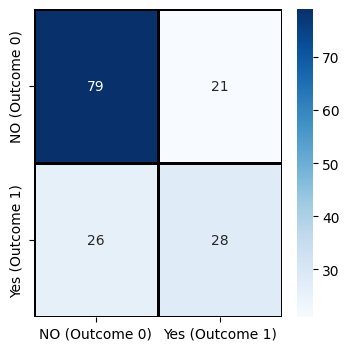

In [22]:
# Fit StandardScaler on TRAINING data only for KMeans to avoid leakage.
scaler_for_kmeans = StandardScaler().fit(X_train_tailored)      # Fit scaler on TRAIN ONLY (avoid leakage)
Z_train_tailored = scaler_for_kmeans.transform(X_train_tailored)# Transform training data to standardized space

kmeans = KMeans(                                                # Create KMeans clustering model
    n_clusters=N_CLUSTERS,                                      # Number of clusters (phenotypes)
    n_init=10,                                                  # Number of random initializations (stability)
    random_state=RANDOM_STATE                                   # Reproducibility
).fit(Z_train_tailored)                                         # Fit KMeans on TRAIN (standardized)


def add_cluster_feature(X, fitted_scaler, fitted_kmeans):
    """
    Append 'cluster_id' predicted by KMeans.
    Steps:
      1) scale X using the TRAIN-fitted scaler (no leakage),
      2) predict cluster labels,
      3) return a copy of X with a numeric 'cluster_id' column.
    """
    Z = fitted_scaler.transform(X)                              # Scale with TRAIN statistics
    clusters = fitted_kmeans.predict(Z)                         # Predict cluster id for each row
    Xc = X.copy()                                               # Copy to avoid modifying original
    Xc["cluster_id"] = clusters.astype("float64")               # Add cluster_id as numeric feature
    return Xc                                                   # Return extended DataFrame

X_train_clustered = add_cluster_feature(                         # Add cluster labels to TRAIN set
    X_train_tailored, scaler_for_kmeans, kmeans
)
X_test_clustered = add_cluster_feature(                          # Add cluster labels to TEST set
    X_test_tailored, scaler_for_kmeans, kmeans
)

pipe_clustered = Pipeline([                                      # Same modeling recipe (scale -> LR)
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, solver="liblinear", random_state=RANDOM_STATE))
])

gs_clustered = GridSearchCV(                                     # CV search on the "clustered" feature space
    estimator = pipe_clustered,
    param_grid = param_grid,
    cv = cv,
    scoring = SCORING,
    n_jobs = -1
)
gs_clustered.fit(X_train_clustered, y_train_tailored)            # Train on TRAIN+cluster_id

clustered_model = gs_clustered.best_estimator_                   # Best pipeline after adding cluster_id
print("\nClustering+Prediction best params:", gs_clustered.best_params_)  # Show chosen hyperparameters
evaluate(clustered_model, X_test_clustered, y_test_tailored,     # Evaluate on TEST+cluster_id
         title="After Clustering + Prediction (cluster_id added)")


# Interpretation: What Changed (vs Baseline)?

# Accuracy stayed the same (69.5%).
→ The total number of correct predictions did not change.

## **Recall for positive class (patients with diabetes) slightly increased from 48.1% to 51.9%.**
→ The model now finds 2 more real diabetic cases than before.

ROC-AUC increased a bit (0.812 → 0.817).
→ The model separates classes slightly better.

**Conclusion**

Adding the cluster ID (from K-Means) gives a small but positive improvement.
The model learns a bit more about hidden patterns in the data — for example,
different “types” of patients — which helps it identify slightly more true diabetic cases.



# C. MODEL ADAPTATION :

Goal:

Show how to detect a change in the data (for example, age distribution) and adapt the model.

Why:

In real life, data changes over time. If the model is not updated, it can give wrong predictions.

# 1- MODEL ADAPTATION (cohort shift: YoungAdults -> OlderAdults)

In [23]:
X_tailored.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Insulin_over_Glucose',
       'BMI_x_Glucose'],
      dtype='object')

In [24]:
# -----------------------------------------------------------------------
# We simulate a meaningful shift by splitting cohorts by Age:
# - Cohort_YoungAdults: Age < 40
# - Cohort_OlderAdults: Age >= 40
#    Plan:
#      A) Define two cohorts (YoungAdults vs OlderAdults) using 'Age'
#      B) Train an initial model on YoungAdults only
#      C) Check drift vs OlderAdults
#      D) Adapt: re-learn clusters on COMBINED (Young+Older) and re-tune LR
#      E) Evaluate on OlderAdults to confirm the adapted model generalizes
# -----------------------------------------------------------------------

if "Age" in X_tailored.columns:                                  # Prefer to split cohorts by Age if available
    mask_young = X_tailored["Age"] < 40                          # Define YoungAdults cohort as Age < 40
else:
    mask_young = X_tailored["Glucose"] < X_tailored["Glucose"].median()  # Fallback: split by median Glucose

X_cohort_young = X_tailored[mask_young].copy()                   # Features for YoungAdults cohort
y_cohort_young = y_full[mask_young].copy()                       # Labels for YoungAdults cohort
X_cohort_older = X_tailored[~mask_young].copy()                  # Features for OlderAdults cohort
y_cohort_older = y_full[~mask_young].copy()                      # Labels for OlderAdults cohort


In [25]:
X_cohort_young.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Insulin_over_Glucose,BMI_x_Glucose
1,1,85,66,29,0,26.6,0.351,31,0.000000,2261.0
2,8,183,64,0,0,23.3,0.672,32,0.000000,4263.9
3,1,89,66,23,94,28.1,0.167,21,1.056180,2500.9
4,0,137,40,35,168,43.1,2.288,33,1.226277,5904.7
5,5,116,74,0,0,25.6,0.201,30,0.000000,2969.6


In [26]:
len(X_cohort_young)

561

In [27]:
X_cohort_older.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Insulin_over_Glucose,BMI_x_Glucose
0,6,148,72,35,0,33.6,0.627,50,0.000000,4972.8
8,2,197,70,45,543,30.5,0.158,53,2.756345,6008.5
9,8,125,96,0,0,0.0,0.232,54,0.000000,0.0
12,10,139,80,0,0,27.1,1.441,57,0.000000,3766.9
13,1,189,60,23,846,30.1,0.398,59,4.476190,5688.9


In [28]:
len(X_cohort_older)

207

## 2-Train/validation within the initial cohort (YoungAdults)

In [29]:
# Train/validation within the initial cohort (YoungAdults)
X_train_initial, X_valid_initial, y_train_initial, y_valid_initial = train_test_split(
    X_cohort_young, y_cohort_young, test_size=0.2, stratify=y_cohort_young, random_state=RANDOM_STATE
)


In [30]:
len(X_train_initial)

448

## 3- Include clustering in this cohort-specific model as well (consistent recipe)


Initial Cohort best params: {'clf__C': 0.1, 'clf__penalty': 'l2'}

=== Model on Initial Cohort (YoungAdults) ===
                 precision    recall  f1-score   support

 NO (Outcome 0)      0.844     0.938     0.889        81
Yes (Outcome 1)      0.783     0.562     0.655        32

       accuracy                          0.832       113
      macro avg      0.814     0.750     0.772       113
   weighted avg      0.827     0.832     0.823       113

ROC-AUC: 0.895


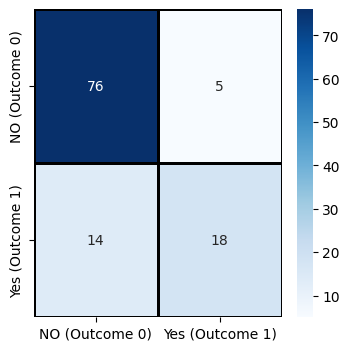

In [31]:
# Include clustering in this cohort-specific model as well (consistent recipe)
scaler_initial_for_kmeans = StandardScaler().fit(X_train_initial) # Fit scaler on YoungAdults TRAIN

Z_train_initial = scaler_initial_for_kmeans.transform(X_train_initial)  # Standardize YoungAdults TRAIN

kmeans_initial = KMeans(                                         # KMeans for YoungAdults cohort
    n_clusters=N_CLUSTERS, n_init=10, random_state=RANDOM_STATE
).fit(Z_train_initial)                                           # Fit KMeans on standardized TRAIN

def add_cluster_initial(X):
    """Add cluster_id predicted from the YoungAdults-trained KMeans."""
    Z = scaler_initial_for_kmeans.transform(X)                   # Scale using YoungAdults TRAIN stats
    cl = kmeans_initial.predict(Z)                               # Predict cluster id
    Xc = X.copy()                                                # Copy to avoid side effects
    Xc["cluster_id"] = cl.astype("float64")                      # Add numeric cluster feature
    return Xc                                                    # Return extended DataFrame

X_train_initial_c = add_cluster_initial(X_train_initial)         # TRAIN with cluster_id (YoungAdults)
X_valid_initial_c = add_cluster_initial(X_valid_initial)         # VALID with cluster_id (YoungAdults)

pipe_initial = Pipeline([                                        # Scale -> LR (initial cohort model)
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, solver="liblinear", random_state=RANDOM_STATE))
])

gs_initial = GridSearchCV(                                       # CV search on initial cohort
    estimator = pipe_initial,
    param_grid = param_grid,
    cv = cv,
    scoring = SCORING,
    n_jobs = -1
)
gs_initial.fit(X_train_initial_c, y_train_initial)               # Fit on YoungAdults TRAIN (+cluster_id)
initial_model = gs_initial.best_estimator_                       # Best initial model
print("\nInitial Cohort best params:", gs_initial.best_params_)  # Show chosen hyperparameters
evaluate(initial_model, X_valid_initial_c, y_valid_initial,      # Evaluate on YoungAdults VALID
         title="Model on Initial Cohort (YoungAdults)")


## 4- Drift detection against the new cohort (OlderAdults)

In [32]:
# -------- Drift detection against the new cohort (OlderAdults) --------
drift_detected = ks_drift(                                       # Compare distributions: YoungAdults TRAIN vs OlderAdults
    X_train_initial, X_cohort_older,
    cols=list(set(X_train_initial.columns) & set(X_cohort_older.columns))
)
print("\nDistribution drift vs. Initial Cohort detected?", drift_detected)  # Print True/False



Distribution drift vs. Initial Cohort detected? True


## 5- Adaptation strategy

In [33]:
# -------- Adaptation strategy --------
# Full adaptation: re-learn clustering on the COMBINED cohorts and re-tune LR.
X_combined = pd.concat([X_train_initial, X_cohort_older], axis=0)  # Combine YoungAdults TRAIN + OlderAdults
y_combined = pd.concat([y_train_initial, y_cohort_older], axis=0)  # Combine corresponding labels


In [34]:
len(X_combined)

655

Adapted Model (Combined Cohorts) best params: {'clf__C': 3, 'clf__penalty': 'l2'}

=== After Adaptation (evaluated on OlderAdults) ===
                 precision    recall  f1-score   support

 NO (Outcome 0)      0.667     0.727     0.696        99
Yes (Outcome 1)      0.727     0.667     0.696       108

       accuracy                          0.696       207
      macro avg      0.697     0.697     0.696       207
   weighted avg      0.698     0.696     0.696       207

ROC-AUC: 0.747


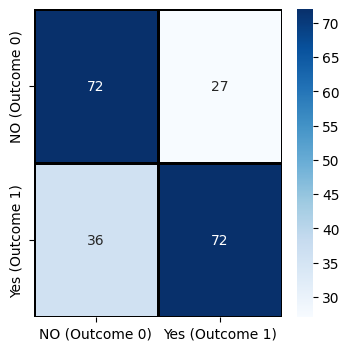

In [35]:
scaler_combined_for_kmeans = StandardScaler().fit(X_combined)    # Fit scaler on the COMBINED data

Z_combined = scaler_combined_for_kmeans.transform(X_combined)    # Standardize COMBINED data

kmeans_combined = KMeans(                                        # KMeans on COMBINED cohorts (learns both)
    n_clusters=N_CLUSTERS, n_init=10, random_state=RANDOM_STATE
).fit(Z_combined)                                                # Fit COMBINED KMeans

def add_cluster_combined(X):
    """Add cluster_id predicted from the COMBINED-cohorts KMeans."""
    Z = scaler_combined_for_kmeans.transform(X)                  # Scale with COMBINED stats
    cid = kmeans_combined.predict(Z)                             # Predict clusters in combined space
    Xc = X.copy()                                                # Copy input
    Xc["cluster_id"] = cid.astype("float64")                     # Add numeric cluster feature
    return Xc                                                    # Return extended DataFrame

X_combined_c = add_cluster_combined(X_combined)                  # COMBINED set with cluster_id
X_older_c    = add_cluster_combined(X_cohort_older)              # OlderAdults set with cluster_id (for eval)

pipe_adapted = Pipeline([                                        # Scale -> LR (adapted model)
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, solver="liblinear", random_state=RANDOM_STATE))
])

gs_adapted = GridSearchCV(                                       # CV search after adaptation
    estimator=pipe_adapted,
    param_grid=param_grid,
    cv=cv,
    scoring=SCORING,
    n_jobs=-1
)
gs_adapted.fit(X_combined_c, y_combined)                         # Train adapted model on combined cohorts

adapted_model = gs_adapted.best_estimator_                       # Best adapted pipeline
print("Adapted Model (Combined Cohorts) best params:", gs_adapted.best_params_)  # Show params
evaluate(adapted_model, X_older_c, y_cohort_older,               # Evaluate adapted model on OlderAdults
         title="After Adaptation (evaluated on OlderAdults)")


## Conclusion: Model adaptation

## Goal

To detect if the data has changed (called drift) between two different groups — Young Adults and Older Adults — and to adapt the model so that it continues to work well on the new group

## Background

The first model was trained only on Young Adults.

When we later tested it on Older Adults, we saw that the data distribution was different.

A KS test confirmed this drift (result: True). → This means the new group behaves differently, so the model must adapt.


## Interpretation :

- Initial model (YoungAdults):

Works very well on the same type of data (Accuracy ≈ 83%, ROC-AUC ≈ 0.895).

**Detects most healthy people correctly but misses some diabetics (recall = 0.562).**

Confusion matrix shows 14 missed positive cases.

- Drift detection:

When we compared both age groups, the statistical test (KS) showed the data had changed — True drift detected.

This means the new (OlderAdults) population has different patterns (e.g., higher glucose or BMI averages).

- After adaptation (OlderAdults):

Accuracy decreased to 0.696 (normal when switching to a harder dataset).

ROC-AUC dropped from 0.895 to 0.747, showing less separability, but still acceptable.

**Recall and precision are balanced around 0.67-0.73, meaning the model treats both classes (healthy and diabetic) fairly.**

Conclusion

After adaptation:

- The model performs consistently across both classes, even in a new age group.
- Even though performance is slightly lower than in the original group, it remains stable and fair, which is the goal of model adaptation.



# HTML Report

In [36]:
# install nbconvert
!pip3 install nbconvert


In [37]:
# Convert the notebook to HTML using the full path
!jupyter nbconvert --to html "/content/drive/MyDrive/UEL-Intelligence-System-Lab/Week03- Lab Tutorial - 5 Marks-adaptive diabetes-risk classifier .ipynb"


[NbConvertApp] Converting notebook /content/drive/MyDrive/UEL-Intelligence-System-Lab/Week03- Lab Tutorial - 5 Marks-adaptive diabetes-risk classifier .ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 486474 bytes to /content/drive/MyDrive/UEL-Intelligence-System-Lab/Week03- Lab Tutorial - 5 Marks-adaptive diabetes-risk classifier .html
